# Encrypted Transfer Learning

In this notebook, we're going to build an encrypted model based on a pretrained model. This will allow us to use already functioning models at our advantage, will retaining protection and privacy both for the data holder and the model owner.

Authors:
 - Alejandro Aristizábal - Github: [@aristizabal95](https://github.com/aristizabal95)
 
This notebook is based on Pysyft's [official tutorial on Encrypted NN](https://github.com/OpenMined/PySyft/blob/dev/examples/tutorials/Part%2012%20-%20Train%20an%20Encrypted%20Neural%20Network%20on%20Encrypted%20Data.ipynb)

## Step 1: Create Workers

This workers will share both the data and the model in an encrypted manner, using Additive Sharing Tensors.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt

import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import syft as sy
import numpy as np

W0710 21:52:26.579699 140735652926336 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/Users/aristizabal95/anaconda3/envs/jupyter/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0710 21:52:26.609668 140735652926336 deprecation_wrapper.py:119] From /Users/aristizabal95/anaconda3/envs/jupyter/lib/python3.7/site-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [3]:
# Set the workers and their hooks
hook = sy.TorchHook(torch)

alice = sy.VirtualWorker(id="alice", hook=hook)
bob = sy.VirtualWorker(id="bob", hook=hook)
james = sy.VirtualWorker(id="james", hook=hook)

## Get the Dataset

For this example, we'll be using a dataset composed of photos of flowers, provided by Kaggle. Get it with [this link](https://www.kaggle.com/alxmamaev/flowers-recognition/downloads/flowers-recognition.zip/2), save it in the home directory of this notebook and extract the zip file to get the directory `flowers/`. **Make sure the directory has this exact name**

**Note:** This dataset contains images of varying sizes, with an average of 320x240 pixels. We will later deal with this 

In [5]:
assert os.path.exists("flowers"), \
"It appears like there's no folder called \"flowers\". \
Did you follow the instructions above?"

### Split the data into train and test datasets

The data obtained from kaggle isn't split between training and testing. This script will do that for you ;)

In [6]:
source_path = 'flowers'
train_path = 'flowers/train'
test_path = 'flowers/test'
test_percent = 0.1 # 10% of the data will be used for testing

##### CREATING THE TRAINING SPLIT ######


# First check if a training path doesn't exist
if not os.path.exists(train_path):
    # Create the training path
    print("Training folder doesn't exist. Creating it")
    os.makedirs(train_path)

    
# Now check if the train folder is empty
if [f for f in os.listdir(train_path) if not f.startswith('.')] == []:
    print("Training folder is empty. Moving data to it")
    datafolders = os.listdir(source_path)
    
    # Exclude the train and test folders if they already exists
    datafolders = list(set(datafolders) - set(['train', 'test']))
    
    for folder in datafolders:
        shutil.move(os.path.join(source_path, folder), train_path)
        

##### CREATING THE TESTING SPLIT ######


# First check if a testing path doesn't exist
if not os.path.exists(test_path):
    # Create the training path
    print("Testing folder doesn't exist. Creating it")
    os.makedirs(test_path)
    

# Now check if the test folder is empty
if [f for f in os.listdir(test_path) if not f.startswith('.')] == []:
    print("Testing folder is empty. Moving data to it")
    
    # Move data from the training set to the testing set
    for folder in os.listdir(train_path):
        if not os.path.exists(os.path.join(test_path, folder)):
            os.makedirs(os.path.join(test_path, folder))
            
        files = sorted(os.listdir(os.path.join(train_path, folder)))
        size = int(len(files)*test_percent)
        rand_files = np.random.choice(files, size, replace=False)
        for file in rand_files:
            shutil.move(os.path.join(train_path, folder, file), os.path.join(test_path, folder, file))

Training folder doesn't exist. Creating it
Training folder is empty. Moving data to it
Testing folder doesn't exist. Creating it
Testing folder is empty. Moving data to it


## Load and Transform our Data

We'll be using PyTorch's ImageFolder class to load our data.
The pretrained models expect the input data to have some properties (e.g. WidthxHeight, normalization, etc). For that, we're going to use transforms.

Our training does not require to be private, since we assume we're the data holders and the model owners. If, on the other hand, our data is either private or distributed along multiple owners, then we must train the model using Federated Learning.

In [100]:
train_transform = transforms.Compose([
                        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomPerspective(),
                        transforms.RandomRotation(30, expand=True),
                        transforms.Resize((224,224)), # Pretrained models work with 224x224
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), # Pretrained models expect this exact normalization

                    ])

test_transform = transforms.Compose([
                        transforms.Resize((224,224)), # Pretrained models work with 224x224
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), # Pretrained models expect this exact normalization

                    ])

trainset = datasets.ImageFolder('flowers/train', transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16)

testset = datasets.ImageFolder('flowers/test', transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16)


In [101]:
trainiter = iter(trainloader)
testiter = iter(testloader)

W0711 13:32:15.236205 140735652926336 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


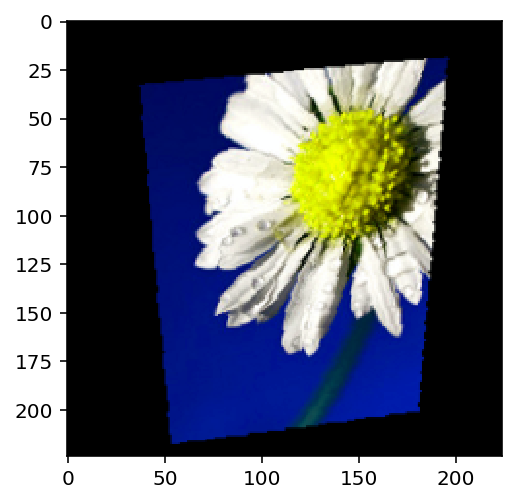

In [153]:
images, labels = trainiter.next()
# Remove normalization
image = images[0].numpy()*np.array([0.229, 0.224, 0.225]).reshape((3,1,1)) + np.array([0.485, 0.456, 0.406]).reshape((3,1,1))
plt.imshow(np.rollaxis(image, 0, 3))

W0711 13:32:15.883292 140735652926336 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.7418136649970393e-09


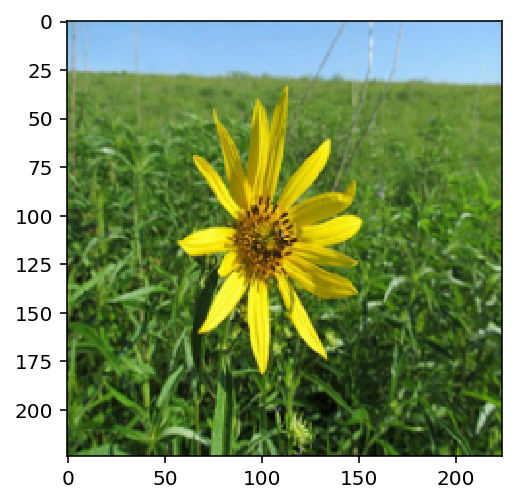

In [154]:
images, labels = testiter.next()
# Remove normalization
image = images[0].numpy()*np.array([0.229, 0.224, 0.225]).reshape((3,1,1)) + np.array([0.485, 0.456, 0.406]).reshape((3,1,1))
print(image.min())
plt.imshow(np.rollaxis(image, 0, 3))

## Get and modify the model

Now that our data is ready, we need to prepare our model. Pytorch has a wide variety of pretrained models to be used for transfer learning. You can find a list of models [here](https://pytorch.org/docs/stable/torchvision/models.html). For this demo we'll be using the VGG Model, but you can use whichever you want.

In [155]:
model = models.vgg11(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /Users/aristizabal95/.cache/torch/checkpoints/vgg11-bbd30ac9.pth
100.0%


Let's inspect the model structure. There's a bunch of convolutional layers, followd by a section called `classifier`. This is the part of the model we want to overwrite.

In [160]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

Let's write our own classifier for the flower images. This classifier must receive the same number of features as the original classifier (25088) and must output the total number of classes we´re classifying (5)

In [167]:
classifier = nn.Sequential(
    nn.Linear(25088,1000),
    nn.ReLU(True), # True: Make the operation in place
    nn.Dropout(),
    nn.Linear(1000,100),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(100,10),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(10,5)
)
print(classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=1000, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=1000, out_features=100, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=100, out_features=10, bias=True)
  (7): ReLU(inplace)
  (8): Dropout(p=0.5)
  (9): Linear(in_features=10, out_features=5, bias=True)
)


Now simply reassign the model's classifier to the one we just defined. Before we do this, we have to also make sure every other parameter is freezed, so that training only affects our own classifier.

In [170]:
for param in model.features.parameters():
    # Freeze all parameters by removing gradients
    param.requires_grad = False

model.classifier = classifier
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern